In [1]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl
import h5py 

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['font.size'] = 8
mpl.rc('image', cmap='gray')
import trackpy as tp
tp.quiet()

import joblib 

import numpy as np
import pandas as pd
import csv, json
import pims
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, linear_sum_assignment
from scipy.spatial import distance_matrix
from tqdm import tqdm
import random

import skimage
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois

np.random.seed(6)
lbl_cmap = random_label_cmap()
# initialize model with versatile fluorescence pretrained weights
model = StarDist2D.from_pretrained('2D_versatile_fluo')
print(model)

run_preprocessing_verb = False

2023-07-21 16:27:26.767019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found model '2D_versatile_fluo' for 'StarDist2D'.


2023-07-21 16:27:41.155785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1

In [2]:
def get_data_preload(startFrame, endFrame, data_preload_path, dataset_name):
    with h5py.File(data_preload_path, 'r') as f:
        dataset = f[dataset_name]
        frameImg = dataset[startFrame:endFrame]
    return frameImg


@pims.pipeline
def preprocessing(image, w, h, x1, y1, x2, y2):
    """
    Preprocessing function for the data.

    Parameters
    ----------
    image : pims.Frame
        Frame of the video.
    x1 : int
        x coordinate of the top left corner of the ROI. (region of interest)
    y1 : int
        y coordinate of the top left corner of the ROI.
    x2 : int    
        x coordinate of the bottom right corner of the ROI.
    y2 : int    
        y coordinate of the bottom right corner of the ROI.

    Returns
    -------
    npImage : np.array
        Preprocessed image.
    """
    npImage = np.array(image)
    alpha = Image.new('L', (h, w), 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha
    ind = np.where(npImage == 0)
    npImage[ind] = npImage[200, 200]
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    # sharpen image https://en.wikipedia.org/wiki/Kernel_(image_processing)
    image_sharp = cv2.filter2D(src=npImage, ddepth=-1, kernel=kernel)
    return npImage

In [3]:
video_selection = "25b25r"

if video_selection == "49b1r":
    print("Import data 49b_1r ...")
    system_name = "49b-1r system"
    source_path = './data/49b1r.mp4'
    path = './49b_1r/'
    part = 1
    data_preload_path = f'/Volumes/ExtremeSSD/UNI/h5_data_thesis/49b-1r/part{part}.h5'

    ref = pims.open(source_path)
    h = 920
    w = 960
    xmin = 55
    ymin = 55
    xmax = 880
    ymax = 880
    data  = preprocessing(ref, h, w, xmin, ymin, xmax, ymax) 
    frames = np.arange(0, 30000, 1)
    fps = 10
    nDrops = 50

elif video_selection == "25b25r":
    print("Import data 25b_25r ...")
    system_name = "25b-25r system"
    source_path = './data/25b25r-1.mp4'
    part = 1
    path = f'./25b_25r/part{part}/'
    data_preload_path = f'/Volumes/ExtremeSSD/UNI/h5_data_thesis/25b-25r/part{part}.h5'
    ref = pims.open(source_path)
    if part == 1:
        rmax = 12
        rmin = 8.3
    if part == 2:
        rmax = 11
        rmin = 7
    h = 480
    w = 640
    xmin = 100
    ymin = 35 
    xmax = 530
    ymax = 465
    data  = preprocessing(ref, h, w, xmin, ymin, xmax, ymax) 
    frames = np.arange(0, 1000000, 1)
    fps = 30
    nDrops = 50
else:
    raise ValueError("No valid video selection")

Import data 25b_25r ...


In [ ]:
if 0:
    #os.remove(data_preload_path)
    hdf = h5py.File(data_preload_path, "a")
    dset = hdf.create_dataset(name  = "dataset_name", shape = (0, data[0].shape[0], data[0].shape[1]),
                              maxshape = (None, data[0].shape[0], data[0].shape[1]), dtype = data[0].dtype)
    for frame in tqdm(frames):
        N = 1
        dset.resize(dset.shape[0] + N, axis=0)
        new_data = data[frame]
        dset[-N:] = new_data
    hdf.close() 
else:
    preprocessed_data = get_data_preload(frames[0], frames[10000], data_preload_path, 'dataset_name')

# FEATURE LOCATION PIPELINE

In [ ]:
## TEST
if 1:
    droplets_found = []
    area = []
    frames_sample = np.random.choice(np.arange(0, preprocessed_data.shape[0], 1), 10, replace=False)

    for frame in tqdm(frames_sample):
        img = preprocessed_data[frame]
        labels_test, dict_test = model.predict_instances(normalize(img), predict_kwargs = {'verbose':False}) 
        droplets_found.append(dict_test['coord'].shape[0])
        test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))
        area += list(test['area'])
        """
        plt.figure(figsize = (10, 5))
        coord, points, prob = dict_test['coord'], dict_test['points'], dict_test['prob']
        ax = plt.subplot(121)
        ax.imshow(img, cmap='gray'); 
        ax.set(title = 'Preprocessed Image', xlabel='x', ylabel='y')
        ax1 = plt.subplot(122, sharex=ax, sharey=ax)
        ax1.imshow(img, cmap='gray'); 
        _draw_polygons(coord, points, prob, show_dist=True)
        ax1.set(title = f"Stardist result - {dict_test['coord'].shape[0]} droplets found", xlabel='x', ylabel='y')
        plt.tight_layout()
        plt.savefig(path + f'test_samples/test{frame}.pdf', format='pdf')
        plt.close()
        """
print(droplets_found)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(np.sqrt(area)/np.sqrt(np.pi))
plt.show()

In [6]:
if 0:
    print("Initialize model with versatile fluorescence pretrained weights...")
    model = StarDist2D.from_pretrained('2D_versatile_fluo')
    print(model)
    print("Starting location process...") 
    area, x, y, prob, frames = [], [], [], [], []
    start = timer()
    for frame in frames:
        segmented_image, dict_test = model.predict_instances(normalize(preprocessed_data[frame-framesList[0]]), \
                                                             predict_kwargs = {'verbose':False})
        test = skimage.measure.regionprops_table(segmented_image, properties=('centroid', 'area'))
        area += list(test['area'])
        y += list(test['centroid-0'])
        x += list(test['centroid-1'])
        prob += list(dict_test['prob'])
        frames += list(np.ones(len(list(test['centroid-0'])))*frame)
    end = timer()
    print(f"Segmentation time: {end-start}")

    # save data
    print("Saving data...")
    df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob, 'frame':frames})
    df['frame'] = df.frame.astype('int')
    df['r'] = np.sqrt(df.area/np.pi)
    df.sort_values(by=['frame', 'prob'], ascending=[True, False], inplace=True)
    df.to_parquet(path + f'df.parquet')
else:
    df = pd.read_parquet(path + 'df.parquet')

# POST PROCESSING OF FEATURE LOCATION 

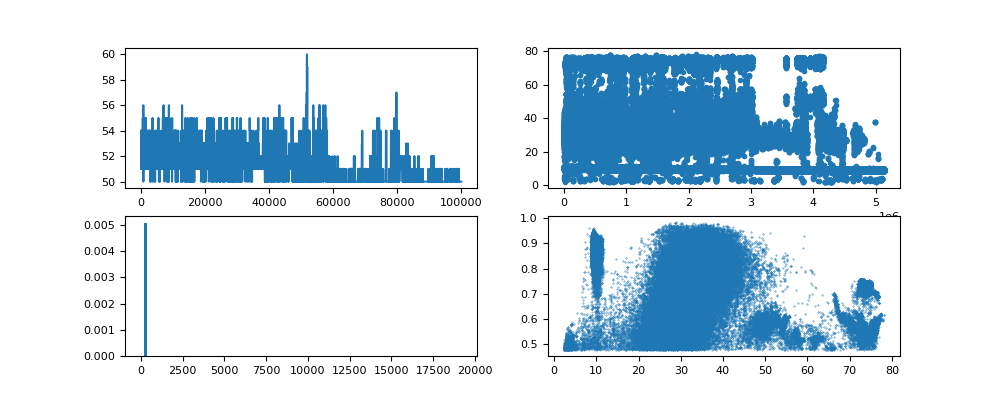

In [7]:
df = pd.read_parquet(path + 'df.parquet')
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
ax[0, 0].plot(df.frame.unique(), df.groupby('frame').count().x.values)
ax[0, 1].plot(df.r, '.')
ax[1, 0].hist(df.area, bins=100, density=True)
ax[1, 1].scatter(df.r, df.prob, s=0.1)
plt.show()

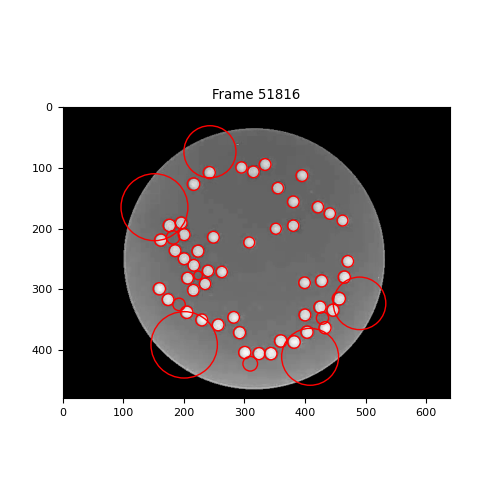

In [20]:
selected_frame = np.where(df.groupby('frame').count().x.values==60)[0][0] + df.frame.min()
img = get_data_preload(selected_frame-df.frame.min(), selected_frame-df.frame.min()+1, data_preload_path, 'dataset_name').reshape(h, w)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(f"Frame {selected_frame}")
ax.imshow(img, cmap='gray')
for i in range(len(df.loc[df.frame == selected_frame])):
    ax.add_artist(plt.Circle((df.loc[df.frame == selected_frame].x.values[i], df.loc[df.frame == selected_frame].y.values[i]), \
                                df.loc[df.frame == selected_frame].r.values[i], color='r', fill=False))
plt.show()

frames: 100000 errors: 1


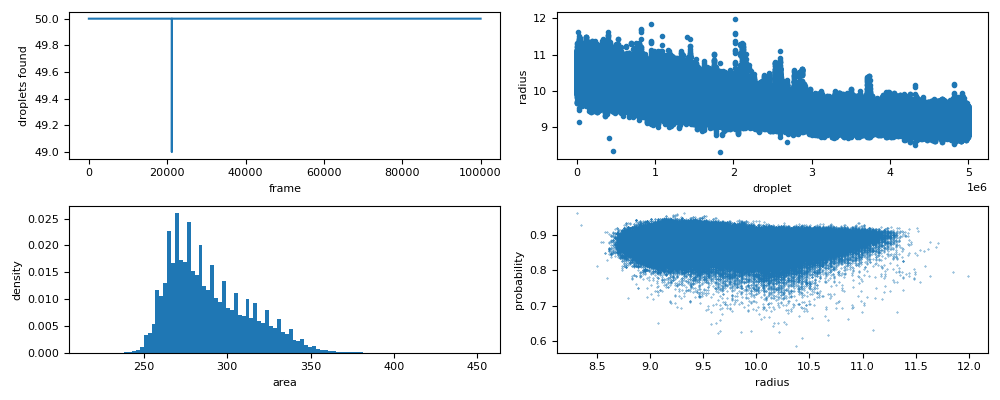

In [35]:
# filter found features
if 1:
    filtered_df = df.loc[df.r.between(rmin, rmax)]
    filtered_df = filtered_df.groupby('frame').apply(lambda x: x.nlargest(nDrops, 'prob'))
    filtered_df = filtered_df.reset_index(drop=True)

print("frames:", len(filtered_df.frame.unique()), "errors:", len(np.where(filtered_df.groupby('frame').count().x.values != nDrops)[0]))
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
ax[0, 0].plot(filtered_df.frame.unique(), filtered_df.groupby('frame').count().x.values)
ax[0, 0].set(xlabel='frame', ylabel='droplets found')
ax[0, 1].plot(filtered_df.r, '.')
ax[0, 1].set(xlabel='droplet', ylabel='radius')
ax[1, 0].hist(filtered_df.area, bins=100, density=True)
ax[1, 0].set(xlabel='area', ylabel='density')
ax[1, 1].scatter(filtered_df.r, filtered_df.prob, s=0.1)
ax[1, 1].set(xlabel='radius', ylabel='probability')
plt.tight_layout()
plt.show()

1 [21183]


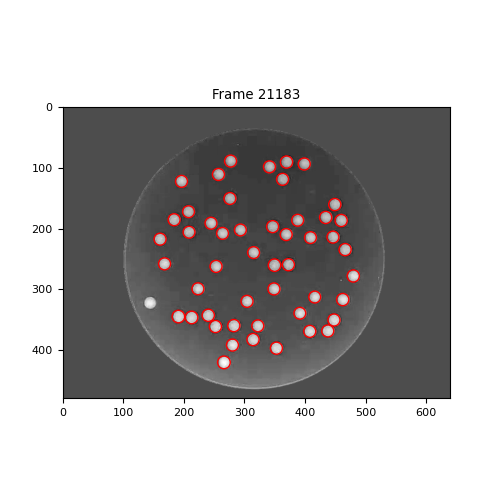

In [36]:
err_frames = np.where(filtered_df.groupby('frame').count().x != nDrops)[0] + filtered_df.frame.min()
err_frame_select = np.random.choice(err_frames, 1)[0]
img = get_data_preload(err_frame_select-df.frame.min(), err_frame_select-df.frame.min()+1, data_preload_path, 'dataset_name').reshape(h, w)

print(len(err_frames), err_frames)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(f"Frame {err_frame_select}")
ax.imshow(img, cmap='gray')
for i in range(len(filtered_df.loc[filtered_df.frame == err_frame_select])):
    ax.add_artist(plt.Circle((filtered_df.loc[filtered_df.frame == err_frame_select].x.values[i],\
                              filtered_df.loc[filtered_df.frame == err_frame_select].y.values[i]), \
                              filtered_df.loc[filtered_df.frame == err_frame_select].r.values[i], color='r', fill=False))
plt.show()

[19097 40401]


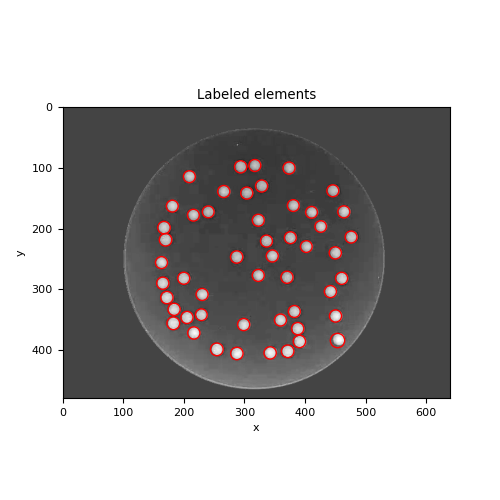

In [39]:
mmmeh_frames = filtered_df.loc[filtered_df.r > 11.8].frame.unique()
print(mmmeh_frames)
frame = mmmeh_frames[0]
df_plot = filtered_df.loc[filtered_df.frame == frame]

img = get_data_preload(frame-filtered_df.frame.min(), frame-filtered_df.frame.min()+1, data_preload_path, 'dataset_name').reshape(h, w)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img, cmap='gray')
for i in range(len(df_plot)):
    ax.add_artist(plt.Circle((df_plot.x.values[i], df_plot.y.values[i]), df_plot.r.values[i], color='r', fill=False))
ax.set(title='Labeled elements', xlabel='x', ylabel='y')
plt.show()

# PRODUCTION OF TRAJECTORIES FROM REFINED FEATURE LOCATION DATA

In [23]:
# Function to interpolate missing values for each group
interp_method = "quadratic"
def interpolate_trajectory(group):
    all_frames = pd.DataFrame({"frame": range(group["frame"].min(), group["frame"].max() + 1)})
    merged = pd.merge(all_frames, group, on="frame", how="left")
    merged.sort_values(by="frame", inplace=True)
    # Interpolate missing values
    merged["x"] = merged["x"].interpolate(method = interp_method)
    merged["y"] = merged["y"].interpolate(method = interp_method)
    merged["r"] = merged["r"].interpolate(method = interp_method)
    merged["area"] = merged["area"].interpolate(method = interp_method)
    merged["prob"] = merged["prob"].interpolate(method = interp_method)
    merged["frame"] = merged["frame"].interpolate(method = interp_method)
    merged["particle"].ffill(inplace=True)
    merged["color"].ffill(inplace=True)
    return merged

In [4]:
#############################################################################################################
#                                         LINK FEATURES WITH TRACKPY                                        #
#############################################################################################################
if 0:
    cutoff = 100
    mem = 227
    t = tp.link_df(df, cutoff, memory = mem, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
    #print(t)
    t = t.sort_values(['frame', 'particle'])

    # filter out short trajectories (less than 25 frames)
    t_filtered = tp.filter_stubs(t, 25)

    # CREATE COLOR COLUMN AND SAVE DF
    n = max(t_filtered.particle)
    print(f"N of droplets: { n + 1}")
    random.seed(5)
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
    for i in range(max(t_filtered.particle)+1-n):
        colors.append("#00FFFF")
    c = []
    for p in t.particle:
        c.append(colors[p])
    t["color"] = c
    t.to_parquet(path + f'df_linked_raw_part{part}.parquet', index=False)

    missing_droplets = {}
    confront_array = np.arange(nDrops)
    for err_frame in err_frames:
        frame_df = t.loc[t.frame == err_frame]
        missing_droplets[err_frame] = np.setdiff1d(confront_array, frame_df.particle.values)[0]
    print(missing_droplets)
    missing_droplets_df = pd.DataFrame.from_dict(missing_droplets, orient='index', columns=['particle'])
    missing_droplets_df['frame'] = missing_droplets_df.index
    missing_droplets_df.reset_index(drop = True, inplace = True)
    missing_droplets_df.to_parquet(path + f'missing_droplets_part{part}.parquet', index=False)

    # fill missing positions, radii, areas and probabilities with interpolation (polynomial order 3)
    trajectories = t.groupby("particle").apply(interpolate_trajectory)
    # Reset the index of the filled dataframe
    trajectories.reset_index(drop=True, inplace=True)
    trajectories["particle"] = trajectories["particle"].astype(int)
    trajectories.to_parquet(path + f'df_linked_part{part}_interpolated.parquet', index=False)
else:
    t = pd.read_parquet(path + 'df_linked_raw.parquet')
    trajectories = pd.read_parquet(path + 'df_linked.parquet')
    missing_droplets = pd.read_parquet(path + 'missing_droplets.parquet')
    print(f"Number of error frames: {len(missing_droplets)}")

Number of error frames: 16


In [24]:
trajectories = t.groupby("particle").apply(interpolate_trajectory)
# Reset the index of the filled dataframe
trajectories.reset_index(drop=True, inplace=True)

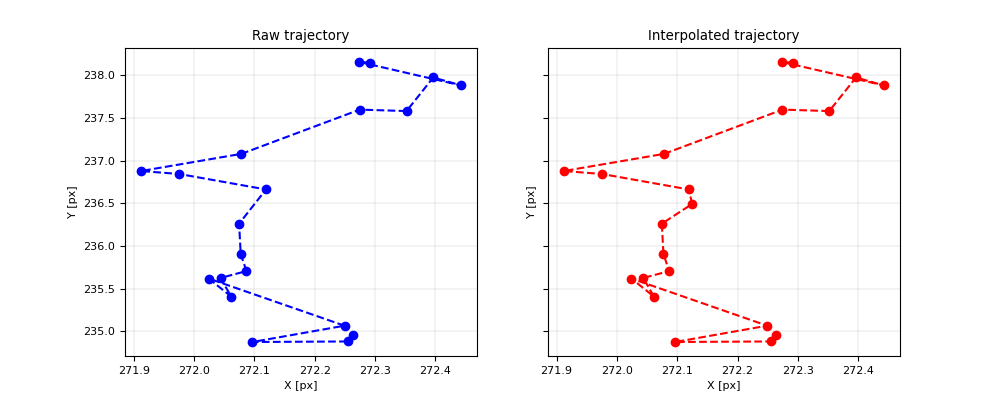

In [25]:
"""
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t.groupby("frame").size(), color = "k", label = "n of droplets")
ax.axhline(nDrops, color = "r", linestyle = "--", label = "correct n")
ax.set(xlabel = "frame", ylabel = "n")
ax.set_title("Number of droplets per frame - pre interpolation")
ax.grid(linewidth = 0.2)
ax.legend()
#plt.savefig(path + 'n_of_droplets_raw.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(trajectories.groupby("frame").size(), color = "k", label = "n of droplets")
ax.axhline(nDrops, color = "r", linestyle = "--", label = "correct n")
ax.set(xlabel = "frame", ylabel = "n")
ax.set_title("Number of droplets per frame - after interpolation")
ax.grid(linewidth = 0.2)
ax.legend()
#plt.savefig(path + 'n_of_droplets.png', bbox_inches='tight')
plt.show()
"""

# example of interpolation
val = 3
raw = t.loc[(t.frame.between(missing_droplets.frame.values[val]-10, missing_droplets.frame.values[val]+10)) & (t.particle == missing_droplets.particle.values[val])]
interpolated = trajectories.loc[(trajectories.frame.between(missing_droplets.frame.values[val]-10, missing_droplets.frame.values[val]+10)) & (trajectories.particle == missing_droplets.particle.values[val])]
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
ax.plot(raw.x, raw.y, '--bo')
ax1.plot(interpolated.x, interpolated.y, '--ro')
ax.set(title='Raw trajectory', xlabel = 'X [px]', ylabel = 'Y [px]')
ax1.set(title='Interpolated trajectory', xlabel = 'X [px]', ylabel = 'Y [px]')
plt.savefig(path + 'interpolation_example.png', bbox_inches='tight')
ax.grid(linewidth = 0.2)
ax1.grid(linewidth = 0.2)
plt.show()

In [ ]:
fig = plt.figure(figsize = (5, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = trajectory.loc[(trajectory.frame == frame) , ["x", "y", "color", "r"]]
    for i in range(len(df)):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.r.values[i]
    graph2.set_data(preprocessed_data[frame-trajectory.frame.min()])
    title.set_text('Tracking raw - frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('Tracking stardist + trackpy - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectory.loc[(trajectory.frame == trajectory.frame.min()), ["x", "y", "color", "r"]]

graph = []
for i in range(len(df)):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], color = df.color.values[i],\
                                           fill = False, linewidth=1)))
graph2 = ax.imshow(preprocessed_data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(trajectory.frame.min(), trajectory.frame.max(), 1), interval = 5, blit=False)
if 1: 
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save(path + 'tracking.mp4', writer=writer, dpi = 300)
plt.close()